In [903]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import tensorflow_lattice as tfl
import keras
# import tf_keras as keras_2 # need keras 2 to fit Lattice model
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
import keras_tuner as kt
from keras import regularizers
# import keras.ops as ops
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from tensorflow.keras.losses import Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l, te
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [904]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)

In [905]:
#-------------------------- generate mean response --------------------------
def generate_output(x1, x2):
    y = np.tanh(50*(np.sin(15*x1) + 0.5))*np.tanh(50*(np.sin(15*x2) - 0.5))
    # y = np.sign(50 * np.sin(5 * np.pi * (x1 - 0.5) * (x2 + 0.5)))
    # y = 2 * np.sin(2 * np.pi * (x1 - 0.5) * (x2 + 0.5))
    return y

In [906]:
#-------------------------- generate function --------------------------
np.random.seed(0)
num_samples = 50_000

# Generate x values
X1 = np.random.uniform(low = -1, high = 1, size = num_samples)
X2 = np.random.uniform(low = -1, high = 1, size = num_samples)
X = np.vstack([X1,X2]).T

# Generate a monotonic function with many turning points
y = generate_output(X1,X2)

# Add random noise to the output
noise = np.random.normal(0, 1, size = X.shape[0])/4
y_noisy = y + noise

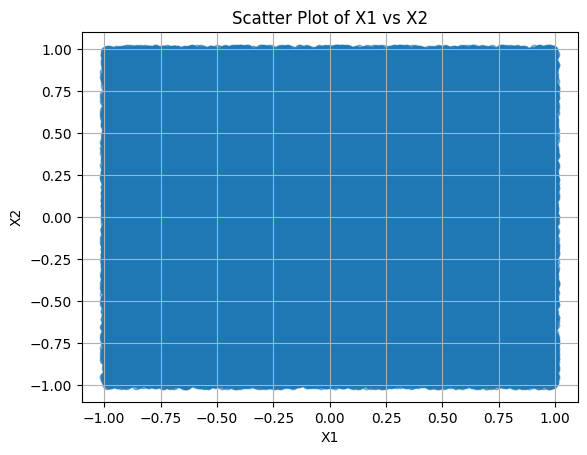

In [907]:
#-------------------------- scatterplot of input feature --------------------------
plt.scatter(X1, X2, alpha = 0.5)  # alpha adds transparency to the points
plt.title('Scatter Plot of X1 vs X2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

In [908]:
#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    X, y_noisy, test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

### View the ground truth

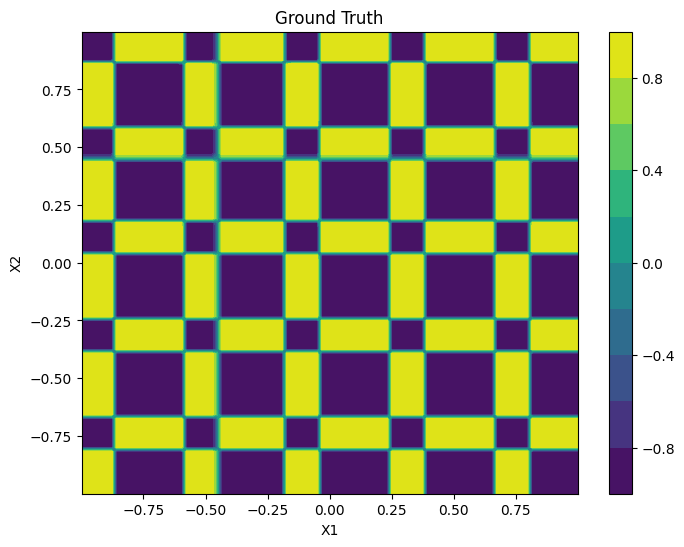

In [909]:
#-------------------------- ground truth --------------------------
# Generate x values
x1, x2 = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 100), np.linspace(X[:,1].min(), X[:,1].max(), 100))

# Generate a monotonic function with many turning points
Y = generate_output(x1,x2)

#-------------------------- plot --------------------------
plt.figure(figsize = (8, 6))
plt.contourf(x1, x2, Y, levels = 10)
plt.colorbar()
plt.title('Ground Truth')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

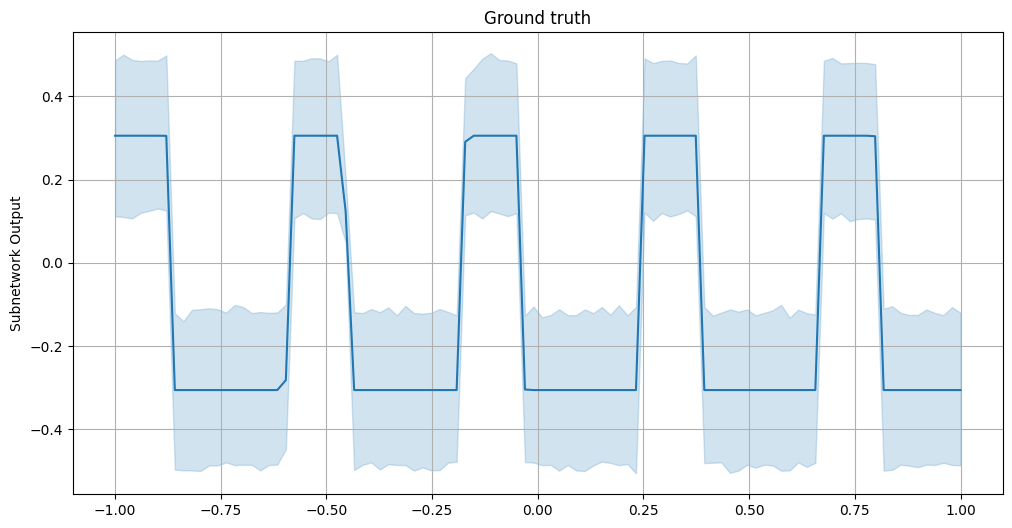

In [931]:
# create univariate plot
plt.figure(figsize = (12, 6))
sns.lineplot(x = x1.ravel(), y = Y.ravel())
# plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Ground truth")
plt.grid(True)
plt.show()

### GAM - Tensor product

In [910]:
# -------------------------- define and fit the GAM model --------------------------
model_gam = GAM(
    s(0) + 
    s(1) +
    te(0, 1),
    n_splines = 25,
    lam = 0.01
)
model_gam.fit(X_main, y_main)

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + te(0, 1) + intercept, tol=0.0001, 
   verbose=False)

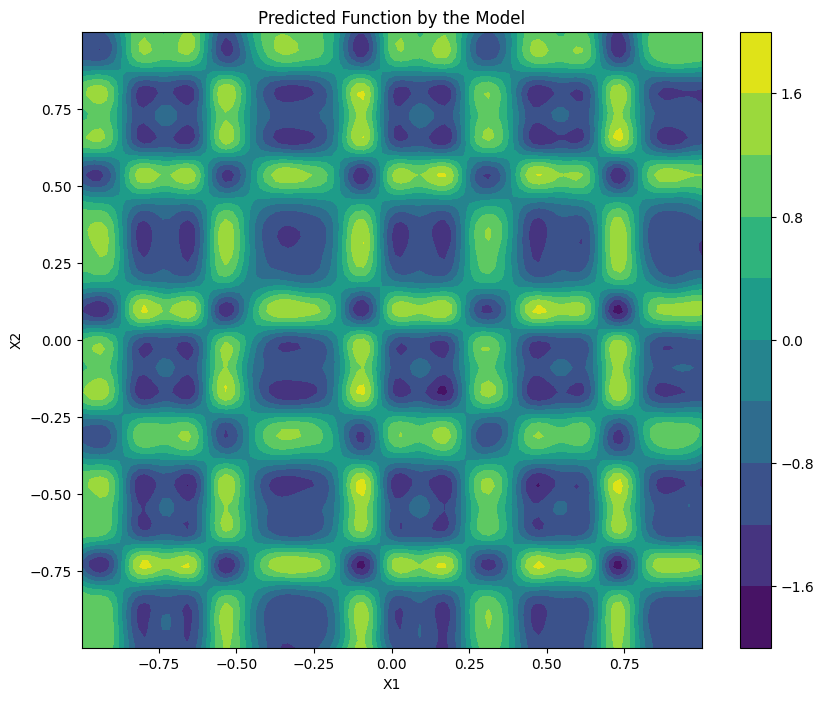

In [911]:
# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
var1_values = np.linspace(X_train[:,0].min(), 
                          X_train[:,0].max(), 
                          grid_length)
var2_values = np.linspace(X_train[:,1].min(), 
                          X_train[:,1].max(), 
                          grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
grid_inputs.append(grid_flat_var1)
grid_inputs.append(grid_flat_var2)
grid_inputs = np.column_stack(grid_inputs)

# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = model_gam.predict(grid_inputs)
# pairwise_predictions = model_gam.partial_dependence(2, grid_inputs)

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"X1")
plt.ylabel(f"X2")
plt.show()

In [912]:
# -------------------------- evaluation --------------------------
gam_pred = model_gam.predict(X_test) # get the prediction

# get metrics on test data
gam_rmse = np.sqrt(mse(y_test, gam_pred))
gam_mae = mae(y_test, gam_pred)
print(f"RMSE: {gam_rmse}")
print(f"MAE: {gam_mae}")

RMSE: 0.5405210659084501
MAE: 0.433899532215872


### Neural Additive Model

In [913]:
# function to create subnet
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for i in range(num_layers):
        num_units = units_per_layer - i*int(units_per_layer/num_layers)
        model.add(Dense(num_units, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(BatchNormalization(scale = False)) # for identifiability
    return model

# function to add subnet output
class AddSubnetOutput(Layer):
    def __init__(self, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.bias = self.add_weight(
            shape = (1,), initializer = 'zeros', trainable = True, name = 'bias'
        )   
    def call(self, inputs):
        subnet_sum = keras.ops.sum(inputs, axis = -1, keepdims = True)
        output = subnet_sum + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

In [914]:
# -------------------- hyperpameters --------------------
activation = "leaky_relu"
interactions = [("X1","X2")]
inputs = []  # input layers
sub_outputs = [] # subnet output

# hypeparameters for tuning
num_neurons_main = 50 # number of neurons for main effects' subnets' hidden layers
num_layers_main = 5 # number of hidden layers for main effects' subnets
num_neurons_interaction = 400 # number of neurons for interaction effects' subnets' hidden layers
num_layers_interaction = 15 # number of hidden layers for interaction effects' subnets
dropout_rate = 0


# -------------------- main effect --------------------
for i in range(2):
    # input layer
    input_layer = Input(shape = (1,), name = f"var_{i+1}")
    inputs.append(input_layer)

    # create subnet for main effect
    subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"var_{i+1}_subnetwork", dropout_rate)
    sub_output = subnet(input_layer)
    sub_outputs.append(sub_output)


# -------------------- pairwise interaction effect --------------------
for (var1, var2) in interactions:
    var1_input = inputs[0]
    var2_input = inputs[1]

    pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
    pairwise_subnet = create_subnet(num_layers_interaction, 
                                    num_neurons_interaction, 
                                    activation, 
                                    f"{var1}_{var2}_subnetwork",
                                    dropout_rate)
    pairwise_dense = pairwise_subnet(pairwise_input_layer)
    sub_outputs.append(pairwise_dense)
    

# -------------------- create the model --------------------
# combine subnets' outputs
main_subnets = Concatenate(name = "subnet_output")(sub_outputs)
final_output = Dense(1)(main_subnets)
# final_output = AddSubnetOutput(name = "final_output")(main_subnets)
model_nam = Model(inputs = inputs, outputs = final_output)

In [915]:
X_train_split = []
X_val_split = []
X_test_split = []
for i in range(2):
    X_train_split.append(X_train[:, i])
    X_val_split.append(X_val[:, i])
    X_test_split.append(X_test[:, i])

In [916]:
# compile
model_nam.compile(optimizer = 'adam',
        loss = "mean_squared_error",
        metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

# fit the model
es = EarlyStopping(restore_best_weights = True, patience = 25)
history = model_nam.fit(
    X_train_split, y_train,
    epochs = 5_000,
    callbacks = [es],
    validation_data = (X_val_split, y_val),
    verbose = 1,
    batch_size = 5_000
)

Epoch 1/5000


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 1.0985 - mean_absolute_error: 0.9779 - root_mean_squared_error: 1.0481 - val_loss: 1.0355 - val_mean_absolute_error: 0.9820 - val_root_mean_squared_error: 1.0176
Epoch 2/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.0274 - mean_absolute_error: 0.9750 - root_mean_squared_error: 1.0136 - val_loss: 1.0328 - val_mean_absolute_error: 0.9804 - val_root_mean_squared_error: 1.0163
Epoch 3/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.0163 - mean_absolute_error: 0.9678 - root_mean_squared_error: 1.0081 - val_loss: 1.0306 - val_mean_absolute_error: 0.9788 - val_root_mean_squared_error: 1.0152
Epoch 4/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 1.0067 - mean_absolute_error: 0.9620 - root_mean_squared_error: 1.0034 - val_loss: 1.0289 - val_mean_absolute_error: 0.9773 - val_root_mean_squared_error: 1.0143
Epoch 5/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.0005 - mean_absolute_error: 0.9562 - root_mean_squared_error: 1.000

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


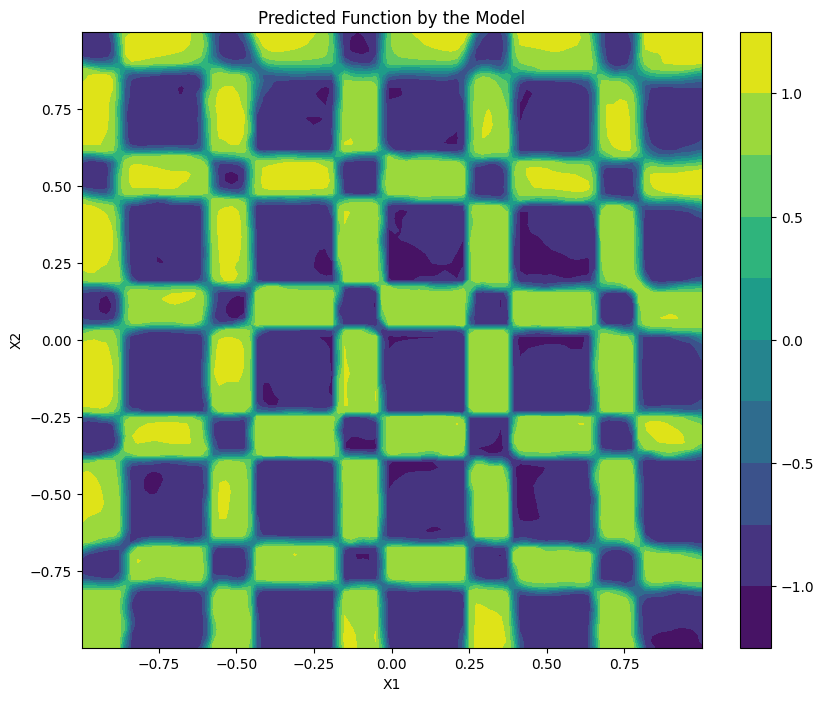

In [917]:
# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
var1_values = np.linspace(X_train[:,0].min(), 
                          X_train[:,0].max(), 
                          grid_length)
var2_values = np.linspace(X_train[:,1].min(), 
                          X_train[:,1].max(), 
                          grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
grid_inputs.append(grid_flat_var1)
grid_inputs.append(grid_flat_var2)
# grid_inputs = np.column_stack(grid_inputs)

# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = model_nam.predict(grid_inputs)

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)

# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"X1")
plt.ylabel(f"X2")
plt.show()

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


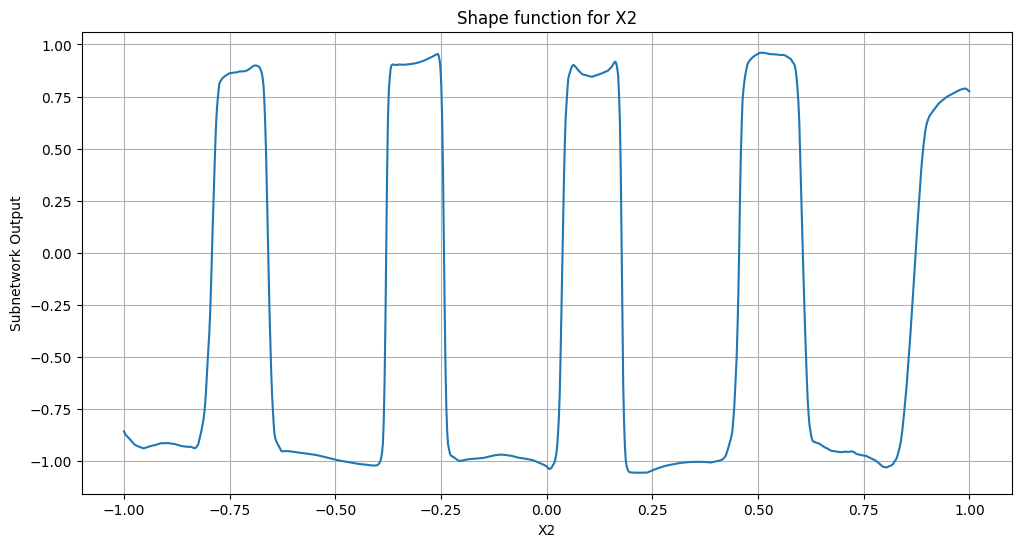

In [918]:
#-------------------------- view the shape function --------------------------
# create a grid
var_name = "X2"
var_index = interactions[0].index(var_name)
grid_length = 1000
grid_inputs = []
grid = np.linspace(X_train[:,var_index].min(), 
                   X_train[:,var_index].max(), 
                   grid_length)
for var in ["X1","X2"]:
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))

# get the prediction
subnet_output = model_nam.predict(grid_inputs)

# create the plot
plt.figure(figsize = (12, 6))
sns.lineplot(x = grid, y = subnet_output[:,0])
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

In [919]:
# -------------------------- evaluation --------------------------
nam_pred = model_nam.predict(X_test_split) # get the prediction

# get metrics on test data
nam_rmse = np.sqrt(mse(y_test, nam_pred))
nam_mae = mae(y_test, nam_pred)
print(f"RMSE: {nam_rmse}")
print(f"MAE: {nam_mae}")

  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 0.4267551645388178
MAE: 0.3046101785324805


### Neural network

In [881]:
#-------------------------- define neural nets architecture --------------------------
num_layers = 15
num_neurons = 400
dropout_rate = 0
activation = "leaky_relu"

# architecture
input_layer = Input((X_train.shape[1],))
x = input_layer
for i in range(num_layers):
    num_units = num_neurons - i*int(num_neurons/num_layers)
    x = Dense(units = num_units, activation = activation)(x)
    x = Dropout(dropout_rate)(x)
output_layer = Dense(1)(x)

# model
model_NN = Model(inputs = input_layer, outputs = output_layer)

# build model
model_NN.compile(optimizer = 'adam',
        loss = "mean_squared_error",
        metrics = [RootMeanSquaredError(), MeanAbsoluteError()])

In [882]:
#-------------------------- compile and fit the model --------------------------
es = EarlyStopping(restore_best_weights = True, patience = 25)

# Fit the model
history = model_NN.fit(
    X_train, y_train,
    epochs = 5_000,
    callbacks = [es],
    validation_data = (X_val, y_val),
    verbose = 1,
    batch_size = 5_000
)

Epoch 1/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 1.0309 - mean_absolute_error: 0.9776 - root_mean_squared_error: 1.0153 - val_loss: 1.0279 - val_mean_absolute_error: 0.9754 - val_root_mean_squared_error: 1.0138
Epoch 2/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1.0231 - mean_absolute_error: 0.9709 - root_mean_squared_error: 1.0115 - val_loss: 1.0264 - val_mean_absolute_error: 0.9727 - val_root_mean_squared_error: 1.0131
Epoch 3/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.0215 - mean_absolute_error: 0.9695 - root_mean_squared_error: 1.0107 - val_loss: 1.0256 - val_mean_absolute_error: 0.9711 - val_root_mean_squared_error: 1.0127
Epoch 4/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.0208 - mean_absolute_error: 0.9681 - root_mean_squared_error: 1.0104 - val_loss: 1.0249 - val_mean_absolute_error: 0.9718 - val_root_mean_squared_error: 1.0124
Epoch 5/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.0202 - mean_absolute_error: 0.9681 - root_mean_squared_

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


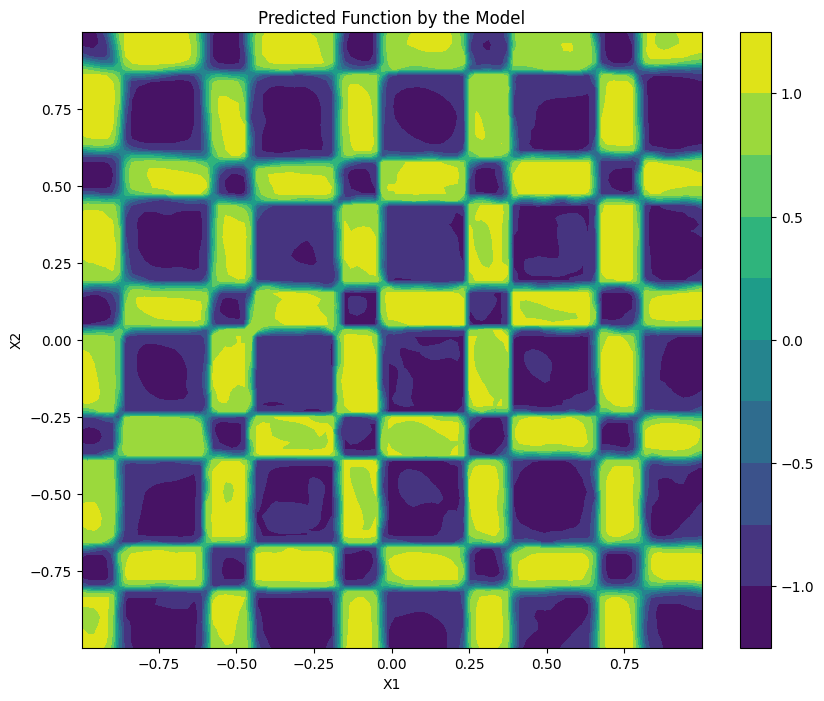

In [883]:
# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
var1_values = np.linspace(X_train[:,0].min(), 
                          X_train[:,0].max(), 
                          grid_length)
var2_values = np.linspace(X_train[:,1].min(), 
                          X_train[:,1].max(), 
                          grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
grid_inputs.append(grid_flat_var1)
grid_inputs.append(grid_flat_var2)
grid_inputs = np.column_stack(grid_inputs)

# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = model_NN.predict(grid_inputs)

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)

# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"X1")
plt.ylabel(f"X2")
plt.show()

In [884]:
# -------------------------- evaluation --------------------------
NN_pred = model_NN.predict(X_test) # get the prediction

# get metrics on test data
NN_rmse = np.sqrt(mse(y_test, NN_pred))
NN_mae = mae(y_test, NN_pred)
print(f"RMSE: {NN_rmse}")
print(f"MAE: {NN_mae}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 0.39141784213386277
MAE: 0.2791207245794958
